## A notebook to create a bar graph of CTs inside AS

## Install and import libraries

In [49]:

%pip install pandas seaborn numpy requests matplotlib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import requests
from  io import StringIO
import textwrap
from pprint import pprint
import matplotlib.ticker as ticker

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Global settings

In [50]:
hra_pop_version = 'v0.12.0'
branch = 'v0.12.0'

output_folder = 'output/ctBar3dAs'

## Load data

In [ ]:
# could also use https://apps.humanatlas.io/api/grlc/hra-pop.html#get-/cell-types-in-atlas
url = f"https://raw.githubusercontent.com/x-atlas-consortia/hra-pop/refs/heads/{branch}/output-data/{hra_pop_version}/reports/atlas-ad-hoc/cell-types-in-anatomical-structurescts-per-as.csv"

headers = {
  'Accept' :'text/csv'
  }

data = requests.get(url=url, headers=headers).text

df = pd.read_csv(StringIO(data))
df

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage,dataset_count
0,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002079,ductal,15.312,0.522523,1
1,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002064,acinar,8.640,0.294840,1
2,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000115,endothelial,3.864,0.131859,1
3,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000738,immune,1.464,0.049959,1
4,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002410,activated_stellate,0.024,0.000819,1
...,...,...,...,...,...,...,...,...,...,...,...
9216,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,15322.464,0.024702,1
9217,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,3691.176,0.005951,1
9218,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),1753.956,0.002828,1
9219,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,970.104,0.001564,1


## Preprocess using `cell-types-level-mapping.csv`

In [52]:
# walk up CTs
csv_response = requests.get(
    f'https://raw.githubusercontent.com/x-atlas-consortia/hra-pop/refs/heads/{branch}/output-data/{hra_pop_version}/reports/atlas-ad-hoc/cell-types-level-mapping.csv', headers={'accept': 'text/csv'}).text

look_up = pd.read_csv(StringIO(csv_response))

look_up

,cell_label,cell_id,level_1_cell_id,level_1_cell_label
0,cell,http://purl.obolibrary.org/obo/CL_0000000,http://purl.obolibrary.org/obo/CL_0000000,unknown cell
1,hematopoietic stem cell,http://purl.obolibrary.org/obo/CL_0000037,http://purl.obolibrary.org/obo/CL_0000034,stem cell
2,fibroblast,http://purl.obolibrary.org/obo/CL_0000057,http://purl.obolibrary.org/obo/CL_0000057,fibroblast
3,epithelial cell,http://purl.obolibrary.org/obo/CL_0000066,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
4,blood vessel endothelial cell,http://purl.obolibrary.org/obo/CL_0000071,http://purl.obolibrary.org/obo/CL_0000000,unknown cell
...,...,...,...,...
191,metallothionein-positive alveolar macrophage,http://purl.obolibrary.org/obo/CL_4033042,http://purl.obolibrary.org/obo/CL_0000235,macrophage
192,lung interstitial macrophage,http://purl.obolibrary.org/obo/CL_4033043,http://purl.obolibrary.org/obo/CL_0000235,macrophage
193,deuterosomal cell,http://purl.obolibrary.org/obo/CL_4033044,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
194,lung migratory dendritic cell,http://purl.obolibrary.org/obo/CL_4033045,http://purl.obolibrary.org/obo/CL_0000451,dendritic cell


In [53]:
df_temp = df
df_temp

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage,dataset_count
0,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002079,ductal,15.312,0.522523,1
1,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002064,acinar,8.640,0.294840,1
2,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000115,endothelial,3.864,0.131859,1
3,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000738,immune,1.464,0.049959,1
4,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002410,activated_stellate,0.024,0.000819,1
...,...,...,...,...,...,...,...,...,...,...,...
9216,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,15322.464,0.024702,1
9217,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,3691.176,0.005951,1
9218,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),1753.956,0.002828,1
9219,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,970.104,0.001564,1


In [54]:
# Merge look-up df with df
df_temp = df.merge(
    look_up[['cell_id','level_1_cell_id','level_1_cell_label']],
    left_on='cell_id',  # Column in main df
    right_on='cell_id',  # Column in lookup df
    how='left'      # Keep all rows from main df
)


df_temp

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
0,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002079,ductal,15.312,0.522523,1,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
1,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002064,acinar,8.640,0.294840,1,http://purl.obolibrary.org/obo/CL_0000152,exocrine cell
2,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000115,endothelial,3.864,0.131859,1,http://purl.obolibrary.org/obo/CL_0000000,unknown cell
3,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000738,immune,1.464,0.049959,1,http://purl.obolibrary.org/obo/CL_0000000,unknown cell
4,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002410,activated_stellate,0.024,0.000819,1,http://purl.obolibrary.org/obo/CL_0000057,fibroblast
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9216,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,15322.464,0.024702,1,http://purl.obolibrary.org/obo/CL_0000000,unknown cell
9217,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,3691.176,0.005951,1,http://purl.obolibrary.org/obo/CL_0000084,T cell
9218,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),1753.956,0.002828,1,NaN,NaN
9219,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,970.104,0.001564,1,NaN,NaN


In [55]:
# show unknown cell IDs
# see also https://github.com/x-atlas-consortia/hra-pop/blob/v0.12.0/output-data/v0.12.0/reports/atlas-ad-hoc/unmapped-cell-ids.csv
unmapped = df_temp[df_temp['level_1_cell_id'].isna()][['organ', 'as_label', 'tool', 'cell_id','cell_label','level_1_cell_id','level_1_cell_label']]
unmapped

,organ,as_label,tool,cell_id,cell_label,level_1_cell_id,level_1_cell_label
57,large intestine,caecum,celltypist,https://purl.org/ccf/ASCTB-TEMP_smc-plpp2-,SMC (PLPP2+),NaN,NaN
58,large intestine,caecum,celltypist,https://purl.org/ccf/ASCTB-TEMP_cycling-plasma...,Cycling plasma cell,NaN,NaN
59,large intestine,caecum,celltypist,https://purl.org/ccf/ASCTB-TEMP_mesoderm-1-hand1-,Mesoderm 1 (HAND1+),NaN,NaN
60,large intestine,caecum,celltypist,https://purl.org/ccf/ASCTB-TEMP_colonocyte,Colonocyte,NaN,NaN
61,large intestine,caecum,celltypist,https://purl.org/ccf/ASCTB-TEMP_goblet-cell,Goblet cell,NaN,NaN
...,...,...,...,...,...,...,...
9210,lung,Left posterior basal segmental bronchus,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_mpo-,MPO+,NaN,NaN
9212,lung,Left posterior basal segmental bronchus,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_cd68-macrophage,CD68+ Macrophage,NaN,NaN
9214,lung,Left posterior basal segmental bronchus,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_smooth-muscle-...,Smooth Muscle Cell,NaN,NaN
9218,lung,Left posterior basal segmental bronchus,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),NaN,NaN


In [56]:
print(f'Number of unmapped IDs: {unmapped['cell_id'].nunique()}')

Number of unmapped IDs: 195


In [57]:
# handle missing values
df_temp['level_1_cell_id'] = df_temp['level_1_cell_id'].fillna('Not crosswalked')
df_temp['level_1_cell_label'] = df_temp['level_1_cell_label'].fillna('Not crosswalked')

In [58]:
df = df_temp

df

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
0,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002079,ductal,15.312,0.522523,1,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
1,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002064,acinar,8.640,0.294840,1,http://purl.obolibrary.org/obo/CL_0000152,exocrine cell
2,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000115,endothelial,3.864,0.131859,1,http://purl.obolibrary.org/obo/CL_0000000,unknown cell
3,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000738,immune,1.464,0.049959,1,http://purl.obolibrary.org/obo/CL_0000000,unknown cell
4,pancreas,http://purl.obolibrary.org/obo/UBERON_0001069,head of pancreas,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002410,activated_stellate,0.024,0.000819,1,http://purl.obolibrary.org/obo/CL_0000057,fibroblast
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9216,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,15322.464,0.024702,1,http://purl.obolibrary.org/obo/CL_0000000,unknown cell
9217,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,3691.176,0.005951,1,http://purl.obolibrary.org/obo/CL_0000084,T cell
9218,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),1753.956,0.002828,1,Not crosswalked,Not crosswalked
9219,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,970.104,0.001564,1,Not crosswalked,Not crosswalked


In [59]:
# filter by tool (azimuth, then celltypist, then popv)
# Function to determine if a row should be kept based on conditions
def filter_rows(df):
    # Step 1: Group by `sex`, `as_label`, and `modality`
    groups = df.groupby(['organ','sex', 'as_label', 'modality'])

    # Step 2: Initialize a list to store the rows to keep
    rows_to_keep = []

    # Step 3: Loop through each group
    for _, group in groups:      
        # If 'azimuth' exists in the group, keep only those rows
        if 'azimuth' in group['tool'].values:
            rows_to_keep.append(group[group['tool'] == 'azimuth'])
        # If no 'azimuth' but 'cell_typist' exists, keep 'cell_typist'
        elif 'celltypist' in group['tool'].values:
            rows_to_keep.append(group[group['tool'] == 'celltypist'])
        # If neither 'azimuth' nor 'cell_typist' exist, keep 'popv'
        elif 'popv' in group['tool'].values:
            rows_to_keep.append(group[group['tool'] == 'popv'])

    # Combine all the rows to keep
    df_filtered = pd.concat(rows_to_keep)
    return df_filtered


# Apply the filtering function
no_proteomics = df[df['tool'] != 'sc_proteomics']
df_filtered = filter_rows(no_proteomics)

# Display the filtered DataFrame
df_filtered

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
1165,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1000718,Inner Medullary Collecting Duct,10748.474,0.216025,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
1167,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_4030016,Distal Convoluted Tubule Type 1,6735.132,0.135364,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
1169,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1001108,Medullary Thick Ascending Limb,3580.251,0.071957,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
1171,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1000768,Connecting Tubule,3390.010,0.068133,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
1173,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1001107,Ascending Thin Limb,3128.057,0.062868,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000814,mature NK T cell,57.353,0.001771,4,http://purl.obolibrary.org/obo/CL_0000084,T cell
4995,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002138,endothelial cell of lymphatic vessel,47.151,0.001456,4,http://purl.obolibrary.org/obo/CL_0000000,unknown cell
4996,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000084,T cell,32.511,0.001004,4,http://purl.obolibrary.org/obo/CL_0000084,T cell
4997,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000236,B cell,23.589,0.000728,4,http://purl.obolibrary.org/obo/CL_0000236,B cell


## Visualize

### Create new labels in the format `{organ}-{as_label}`

In [60]:
# create new labels with organ and as_label so y-axis is sorted and grouped by organ
df_filtered['organ_as_label'] = df_filtered['organ']+" - "+df_filtered['as_label']
df_filtered

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label,organ_as_label
1165,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1000718,Inner Medullary Collecting Duct,10748.474,0.216025,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell,Left kidney - kidney capsule
1167,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_4030016,Distal Convoluted Tubule Type 1,6735.132,0.135364,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell,Left kidney - kidney capsule
1169,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1001108,Medullary Thick Ascending Limb,3580.251,0.071957,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell,Left kidney - kidney capsule
1171,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1000768,Connecting Tubule,3390.010,0.068133,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell,Left kidney - kidney capsule
1173,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1001107,Ascending Thin Limb,3128.057,0.062868,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell,Left kidney - kidney capsule
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000814,mature NK T cell,57.353,0.001771,4,http://purl.obolibrary.org/obo/CL_0000084,T cell,urinary bladder - trigone of urinary bladder
4995,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002138,endothelial cell of lymphatic vessel,47.151,0.001456,4,http://purl.obolibrary.org/obo/CL_0000000,unknown cell,urinary bladder - trigone of urinary bladder
4996,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000084,T cell,32.511,0.001004,4,http://purl.obolibrary.org/obo/CL_0000084,T cell,urinary bladder - trigone of urinary bladder
4997,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000236,B cell,23.589,0.000728,4,http://purl.obolibrary.org/obo/CL_0000236,B cell,urinary bladder - trigone of urinary bladder


### Get colors from Color Brewer

In [61]:
def create_consistent_color_mapping(df, colors_file_path):
    # Get all unique cell types from the entire dataset
    all_cell_types = df['level_1_cell_label'].unique()

    # Read colors from the text file
    with open(colors_file_path, 'r') as file:
        # Assuming each line in the file contains one color code
        colors = [line.strip() for line in file.readlines()]

    # Create color dictionary
    color_map = {}
    for i, cell_type in enumerate(all_cell_types):
        # Cycle through colors if more than available
        color_idx = i % len(colors)
        color_map[cell_type] = colors[color_idx]
    pprint(color_map)
    return color_map

In [62]:
# Read colors from file
with open('data/colors.txt', 'r') as file:
    colors = [line.strip() for line in file.readlines()]

# Create color mapping using function defined above
color_map = create_consistent_color_mapping(df, "data/colors.txt")

{'B cell': '#e31a1c',
 'Not crosswalked': '#ff7f00',
 'T cell': '#fdbf6f',
 'adipocyte': '#a6cee3',
 'blood cell': '#6a3d9a',
 'cardiac muscle cell': '#1f78b4',
 'dendritic cell': '#fb8072',
 'endocrine cell': '#fb9a99',
 'epithelial cell': '#a6cee3',
 'exocrine cell': '#1f78b4',
 'fibroblast': '#33a02c',
 'glial cell': '#fdb462',
 'macrophage': '#8dd3c7',
 'melanocyte': '#b2df8a',
 'monocyte': '#cab2d6',
 'natural killer cell': '#80b1d3',
 'neuron': '#bebada',
 'smooth muscle cell': '#ffff99',
 'stem cell': '#b3de69',
 'stromal cell': '#b15928',
 'unknown cell': '#b2df8a'}


### Build visualizations

In [63]:

def wrap_labels(ax, width, axis='y', break_long_words=False):
  """Wraps the labels of the specified axis to a maximum width.

  Args:
      ax (matplotlib.axes.Axes): The axes object.
      width (int): The maximum width of the labels.
      axis (str, optional): The axis to wrap ('x' or 'y'). Defaults to 'y'.
      break_long_words (bool, optional): Whether to break words longer than
                                        the width. Defaults to False.
  """
  if axis == 'y':
      labels = []
      for label in ax.get_yticklabels():
          text = label.get_text()
          labels.append(textwrap.fill(text, width=width,
                        break_long_words=break_long_words))
      ax.set_yticklabels(labels, rotation=0)
  elif axis == 'x':
      labels = []
      for label in ax.get_xticklabels():
            text = label.get_text()
            labels.append(textwrap.fill(text, width=width,
                          break_long_words=break_long_words))
      ax.set_xticklabels(labels, rotation=0)

In [64]:
# Set the figure size globally
sns.set_theme(rc={'figure.figsize': (10, 50)})

In [70]:
def build_stacked_bar_graph(sex: str, df: pd.DataFrame, color_map: dict):
    """Build a stacked horizontal bar graph for a given sex using cell type colors."""

    # Set font sizes globally
    plt.rcParams.update({
        "axes.labelsize": 40,
        "xtick.labelsize": 35,
        "ytick.labelsize": 30,
        "legend.fontsize": 12,
        "legend.title_fontsize": 12
    })

    # Filter data by sex
    df_sex = df[df['sex'] == sex]

    # Group and pivot data
    grouped = df_sex.groupby(['organ_as_label', 'level_1_cell_label'])[
        'cell_percentage'].sum().reset_index()
    pivot_df = grouped.pivot(
        index='organ_as_label', columns='level_1_cell_label', values='cell_percentage').fillna(0)

    # Plot
    colors = [color_map[cell_type] for cell_type in pivot_df.columns]
    ax = pivot_df.plot(kind='barh', stacked=True, color=colors)

    # Style axes
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([0.25, 0.5, 0.75])
    ax.set_xticklabels(['25%', '50%', '75%'])

    # Minor ticks and tick marks
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(ticker.FixedLocator([0.25, 0.5, 0.75]))
    ax.tick_params(axis='x', which='major', length=10, width=2)
    ax.tick_params(axis='x', which='minor', length=5, width=1, color='gray')

    # Grid lines
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    # Remove legend and apply label wrapping
    ax.get_legend().remove()
    wrap_labels(ax, 35, axis='y')

    # Tweak label spacing
    for label in ax.get_yticklabels():
        label.set_linespacing(1)

    # Ensure tick marks are visible
    ax.spines['top'].set_visible(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')
    
    # Set background to white
    fig = ax.get_figure()
    fig.patch.set_facecolor('white')  # Set figure background
    ax.set_facecolor('white')         # Set axes (plot area) background

    # Save and display
    plt.savefig(f"output/stacked_bar_graph_{sex}.png",
                dpi=600, format='png', bbox_inches='tight')
    plt.show()
    plt.close()

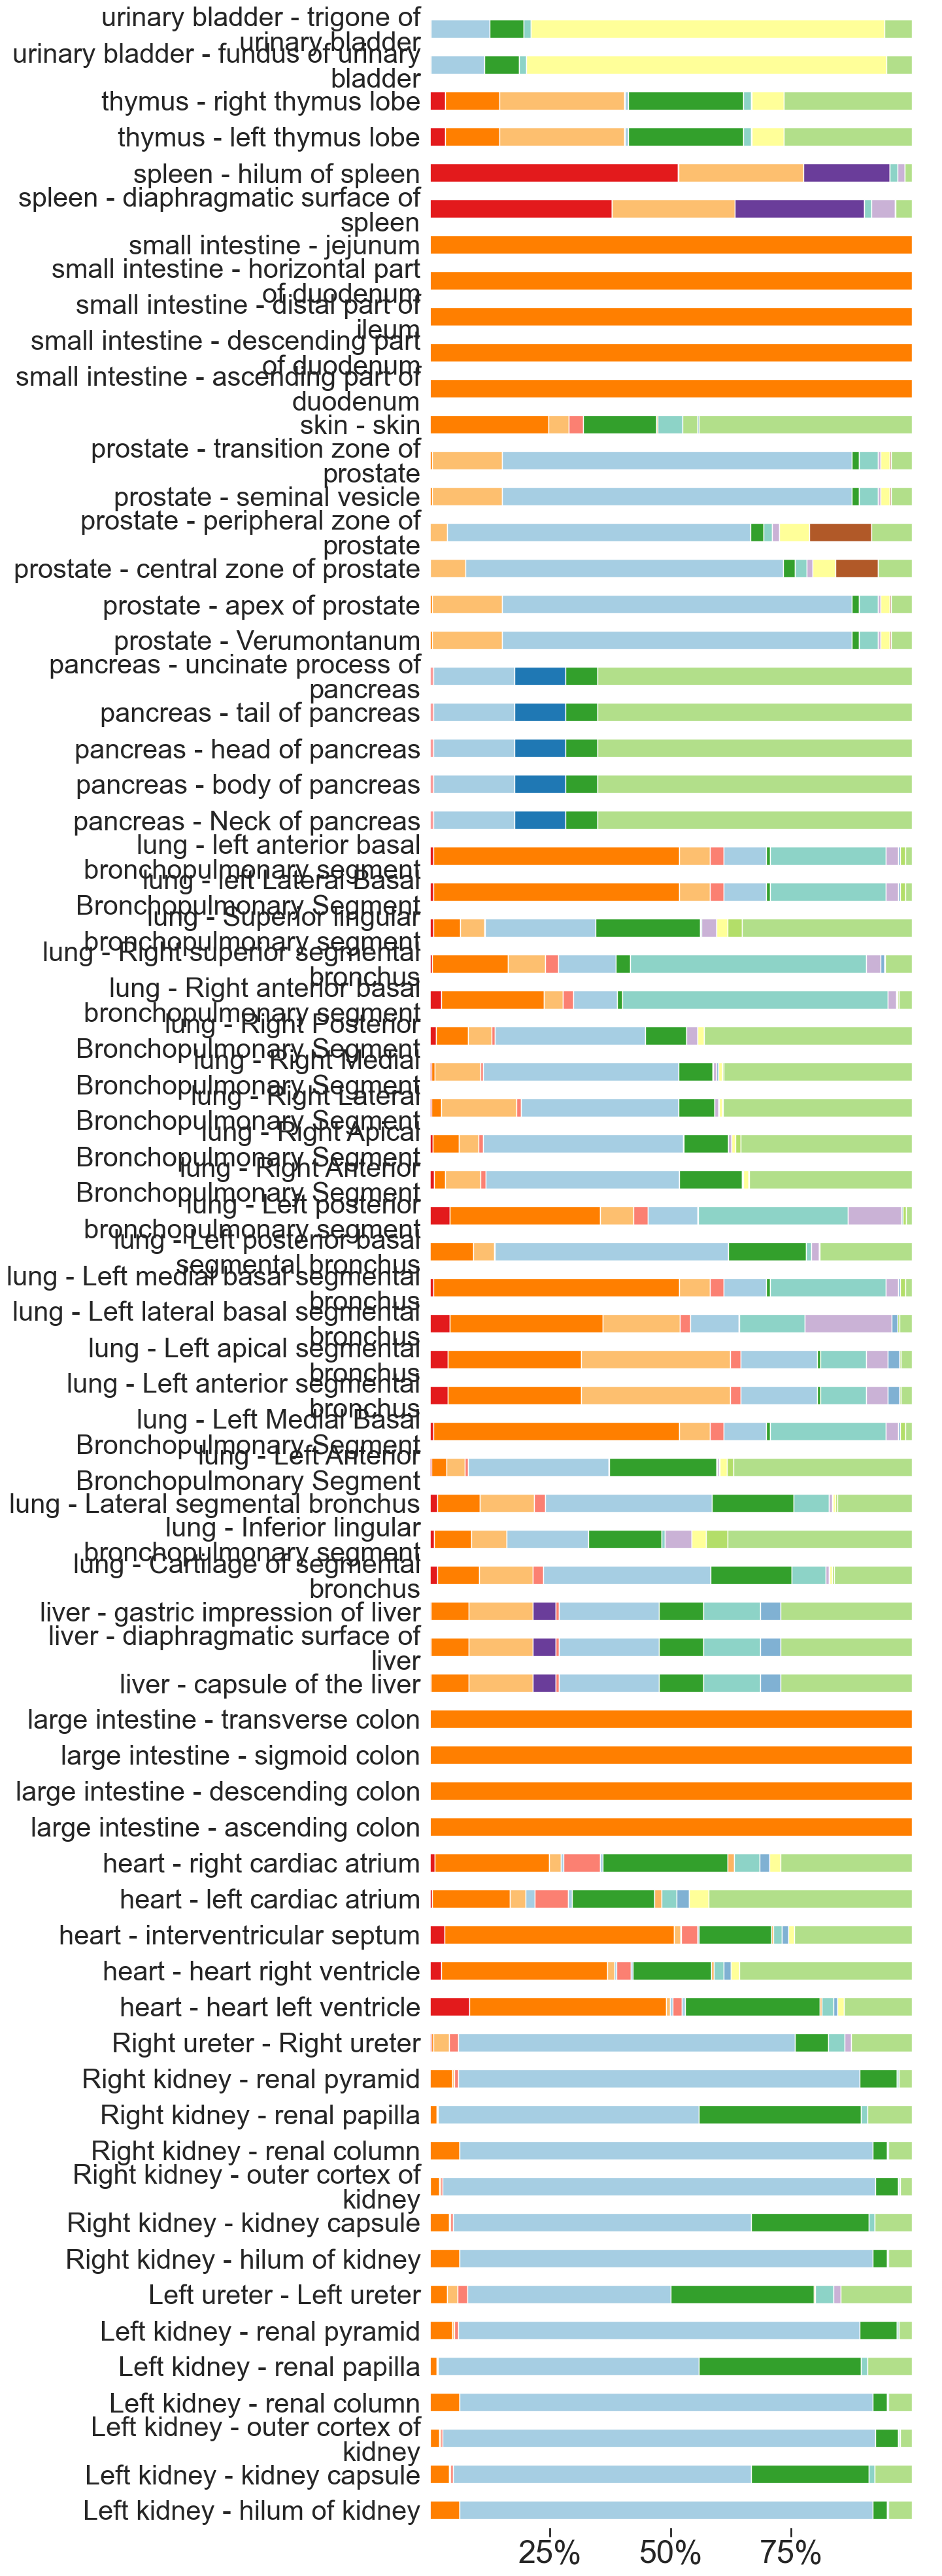

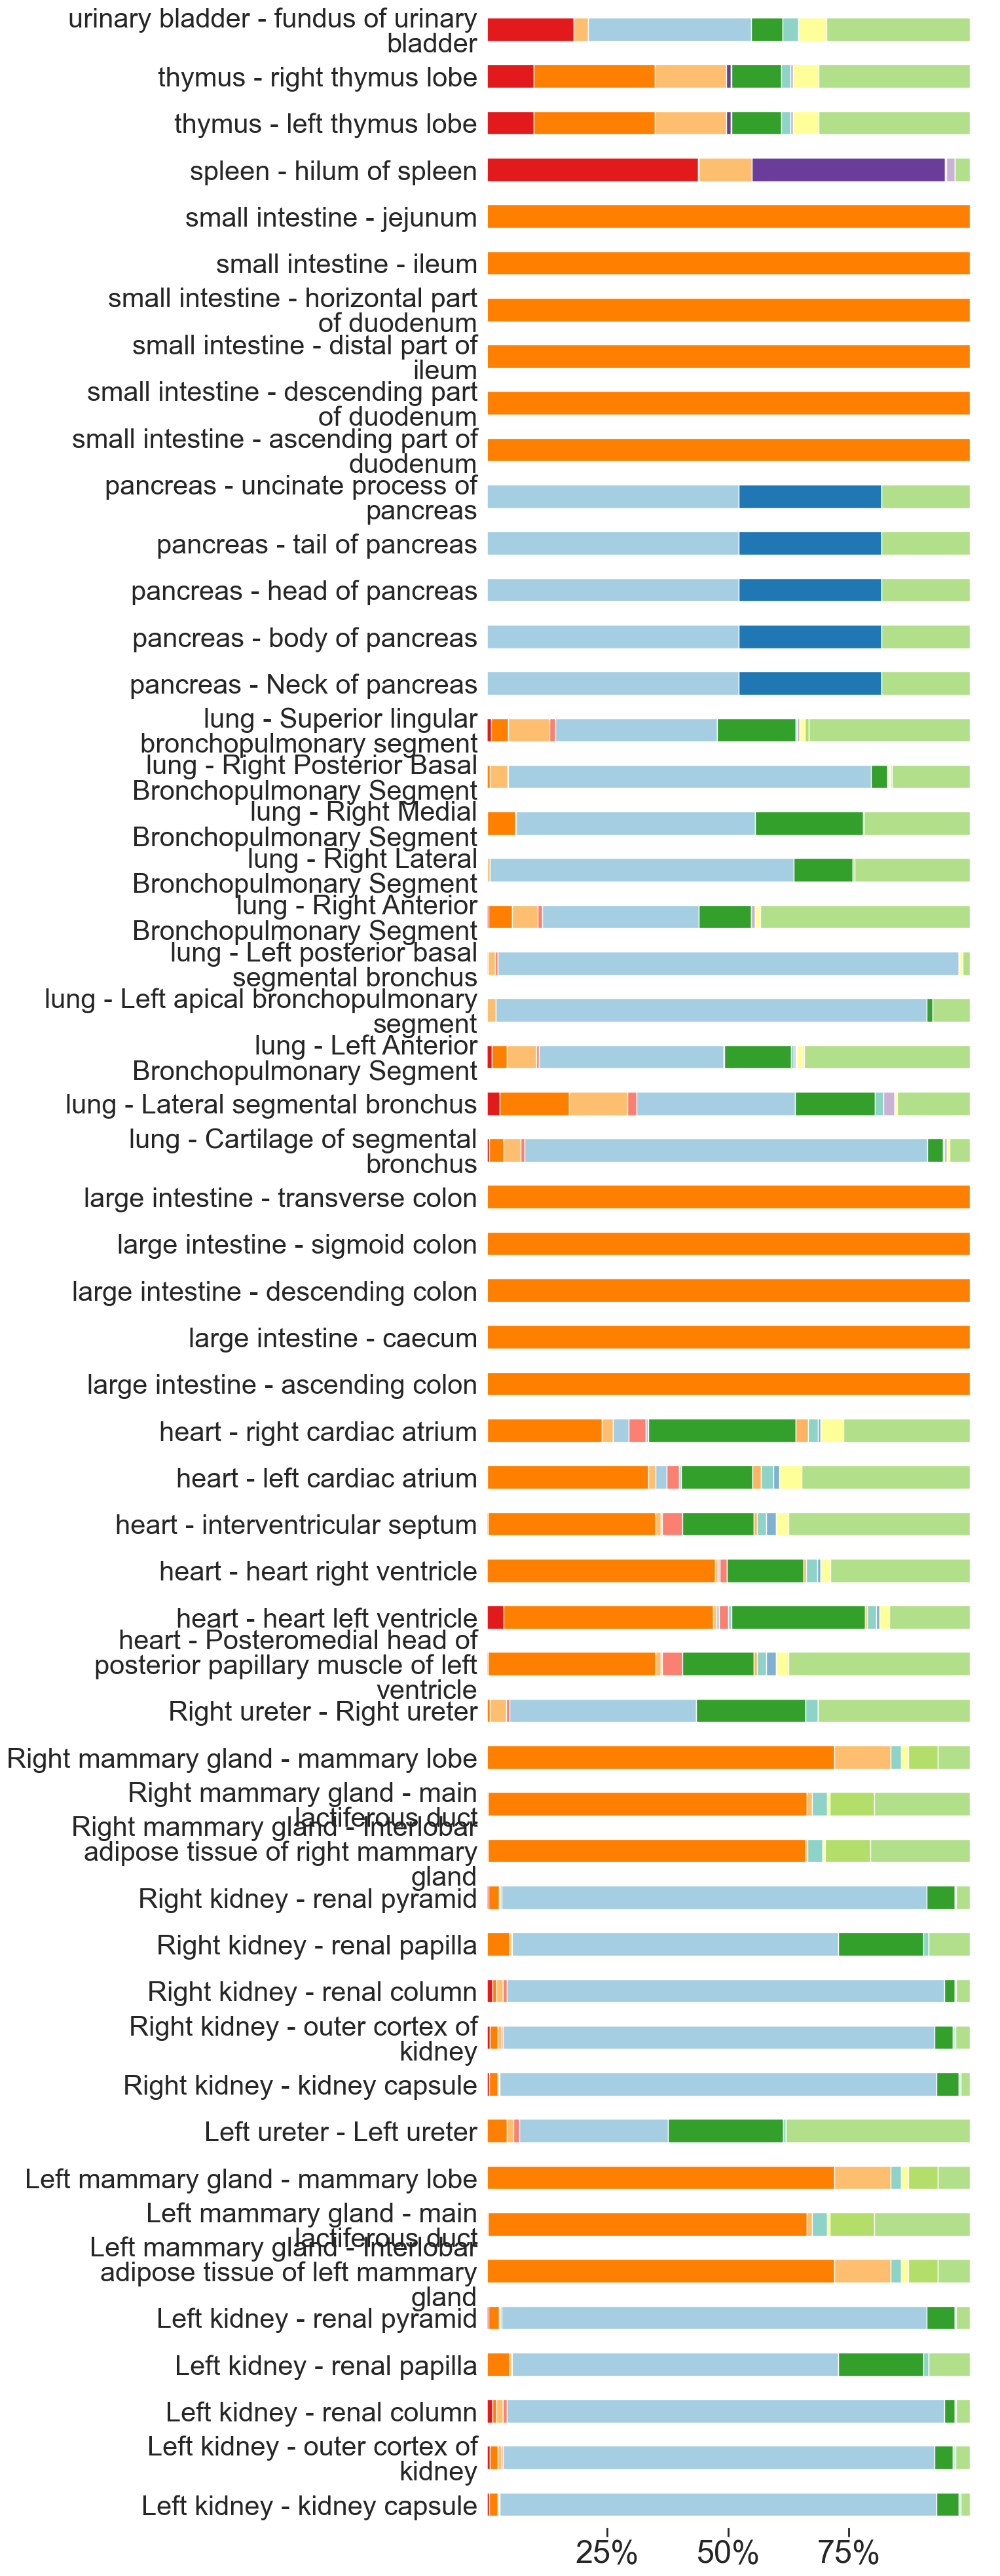

In [71]:
# build visualization
build_stacked_bar_graph('Male', df_filtered, color_map=color_map)
build_stacked_bar_graph('Female', df_filtered, color_map=color_map)

## Make look-up for `as_label` to `node_name`

In [72]:
url = 'https://cdn.humanatlas.io/digital-objects/ref-organ/asct-b-3d-models-crosswalk/v1.7/assets/asct-b-3d-models-crosswalk.csv'
df_crosswalk = pd.read_csv(url, skiprows=10)
df_crosswalk

,anatomical_structure_of,source_spatial_entity,node_name,label,OntologyID,representation_of,node_type,glb file of single organs,Ref/1,Ref/1/ID
0,-,#VHFemaleOrgans,VH_F_integumentary_system,integumentary system layer,UBERON:0013754,http://purl.obolibrary.org/obo/UBERON_0013754,organizational,3d-vh-f-united,NaN,NaN
1,#VHFSkinV1.1,#VHFemaleOrgans,VH_F_skin,skin of body,UBERON:0002097,http://purl.obolibrary.org/obo/UBERON_0002097,mesh,3d-vh-f-skin,NaN,NaN
2,-,-,VH_F_mammary_gland,-,-,-,organizational,-,NaN,NaN
3,#VHFLeftMammaryGland,#VHFemaleOrgans,VH_F_mammary_gland_L,Left mammary gland,FMA:57991,http://purl.org/sig/ont/fma/fma57991,organizational,3d-vh-f-mammary-gland-l,NaN,NaN
4,#VHFLeftMammaryGland,#VHFemaleOrgans,VH_F_fat_L,Interlobar adipose tissue of left mammary gland,FMA:73166,http://purl.org/sig/ont/fma/fma73166,mesh,3d-vh-f-mammary-gland-l,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2108,#VHMVertebrae,#VHMaleOrgans,VH_M_lumbar_vertebra_1,lumbar vertebra 1,UBERON:0004617,http://purl.obolibrary.org/obo/UBERON_0004617,mesh,VH_M_Vertebrae,NaN,NaN
2109,#VHMVertebrae,#VHMaleOrgans,VH_M_lumbar_vertebra_2,lumbar vertebra 2,UBERON:0004618,http://purl.obolibrary.org/obo/UBERON_0004618,mesh,VH_M_Vertebrae,NaN,NaN
2110,#VHMVertebrae,#VHMaleOrgans,VH_M_lumbar_vertebra_3,lumbar vertebra 3,UBERON:0004619,http://purl.obolibrary.org/obo/UBERON_0004619,mesh,VH_M_Vertebrae,NaN,NaN
2111,#VHMVertebrae,#VHMaleOrgans,VH_M_lumbar_vertebra_4,lumbar vertebra 4,UBERON:0004620,http://purl.obolibrary.org/obo/UBERON_0004620,mesh,VH_M_Vertebrae,NaN,NaN


In [73]:
# only keep relevant rows
df_filtered

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label,organ_as_label
1165,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1000718,Inner Medullary Collecting Duct,10748.474,0.216025,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell,Left kidney - kidney capsule
1167,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_4030016,Distal Convoluted Tubule Type 1,6735.132,0.135364,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell,Left kidney - kidney capsule
1169,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1001108,Medullary Thick Ascending Limb,3580.251,0.071957,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell,Left kidney - kidney capsule
1171,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1000768,Connecting Tubule,3390.010,0.068133,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell,Left kidney - kidney capsule
1173,Left kidney,http://purl.obolibrary.org/obo/UBERON_0002015,kidney capsule,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1001107,Ascending Thin Limb,3128.057,0.062868,5,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell,Left kidney - kidney capsule
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000814,mature NK T cell,57.353,0.001771,4,http://purl.obolibrary.org/obo/CL_0000084,T cell,urinary bladder - trigone of urinary bladder
4995,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002138,endothelial cell of lymphatic vessel,47.151,0.001456,4,http://purl.obolibrary.org/obo/CL_0000000,unknown cell,urinary bladder - trigone of urinary bladder
4996,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000084,T cell,32.511,0.001004,4,http://purl.obolibrary.org/obo/CL_0000084,T cell,urinary bladder - trigone of urinary bladder
4997,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000236,B cell,23.589,0.000728,4,http://purl.obolibrary.org/obo/CL_0000236,B cell,urinary bladder - trigone of urinary bladder


In [74]:
# export relevant columns
subset = df_crosswalk[['label', 'node_name', 'anatomical_structure_of']]
export = subset[subset['label'].isin(df_filtered['as_label'])]
export.to_csv('output/ctBar3dAs/crosswalk.csv', index=False)